In [239]:
from numpy import array, min, argmin, linspace
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import re
import json
import urllib.request

## Выделение документов из коллекции для каждого класса

In [303]:
model = []
with open("../server/hartm.mdl", "rb") as file:
    model = pickle.load(file)

In [304]:
TOP_N_WORDS = 10
phi0 = model["phi_0"]
phi0_topic_columns = list(filter(lambda t: t.startswith("topic_"), phi0.columns))
phi0 = phi0[phi0_topic_columns]
theta = model["theta"]
theta0_topic_columns = list(filter(lambda t: re.match("level_0_topic_*", t), theta.index))
theta0 = theta.loc[theta0_topic_columns, :]

In [305]:
WORDS_TO_CLASSIFICATION_DICT=1000
top_tags = zip(theta0.index, phi0.index[phi0.values.argsort(axis=0)[-WORDS_TO_CLASSIFICATION_DICT:][::-1].T])
for topic, words in top_tags:
    print(topic, ":", words[:5])

level_0_topic_0 : ['россия' 'история_россии' 'философия' 'история' 'география']
level_0_topic_1 : ['эволюция' 'антропология' 'человек' 'палеонтология' 'антропогенез']
level_0_topic_2 : ['экономика' 'сша' 'квантовые_технологии' 'квантовый_компьютер'
 'религиоведение']
level_0_topic_3 : ['культура' 'литература' 'массовая_культура' 'культурология' 'философия']
level_0_topic_4 : ['история' 'политика' 'ссср' 'христианство' 'религия']
level_0_topic_5 : ['астрономия' 'астрофизика' 'космос' 'звезды' 'галактика']
level_0_topic_6 : ['язык' 'лингвистика' 'филология' 'право' 'русский_язык']
level_0_topic_7 : ['социология' 'социология_повседневности' 'общество' 'дюркгейм_эмиль'
 'вебер_макс']
level_0_topic_8 : ['общество' 'государство' 'россия' 'идентичность' 'китай']
level_0_topic_9 : ['психология' 'искусственный_интеллект' 'интернет' 'когнитивная_психология'
 'мышление']
level_0_topic_10 : ['медицина' 'клетка' 'биомедицина' 'белки' 'онкология']
level_0_topic_11 : ['физика' 'квантовая_физика' 'физ

In [306]:
tech_topics_ids = theta0.index[[5,11,13,15]]
hum_topics_ids = theta0.index[[0,3,4,6,8,12]]
natural_topics_ids = theta0.index[[1,10,16,17,18]]

In [307]:
import re
theta0 = theta.loc[list(filter(lambda t: re.match("level_0_topic_*", t), theta.index))]

theta_tech = theta0.loc[tech_topics_nums, :]
theta_hum = theta0.loc[hum_topics_nums, :]
theta_natural = theta0.loc[natural_topics_nums, :]

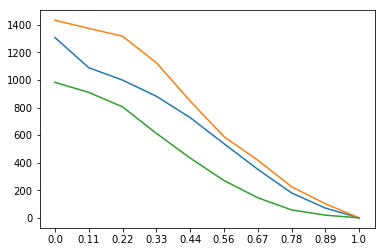

In [308]:
def docs_num_by_threshold(thresold):
    nearest_topic_for_doc = theta0[theta0 > thresold].idxmax().dropna()
    tech_docs = [doc for doc in nearest_topic_for_doc.index if nearest_topic_for_doc[doc] in tech_topics_ids]
    hum_docs = [doc for doc in nearest_topic_for_doc.index if nearest_topic_for_doc[doc] in hum_topics_ids]
    natural_docs = [doc for doc in nearest_topic_for_doc.index if nearest_topic_for_doc[doc] in natural_topics_ids]
    return len(tech_docs), len(hum_docs), len(natural_docs)

for pl in array([docs_num_by_threshold(tr) for tr in linspace(0, 1, 10)]).T:
    plt.plot(pl)
    
plt.xticks(range(10), linspace(0, 1, 10).round(2))
plt.show()

In [309]:
def docs_by_threshold(thresold):
    nearest_topic_for_doc = theta0[theta0 > thresold].idxmax().dropna()
    tech_docs_ids = [doc for doc in nearest_topic_for_doc.index if nearest_topic_for_doc[doc] in tech_topics]
    hum_docs_ids = [doc for doc in nearest_topic_for_doc.index if nearest_topic_for_doc[doc] in hum_topics]
    natural_docs_ids = [doc for doc in nearest_topic_for_doc.index if nearest_topic_for_doc[doc] in natural_topics]
    return set(tech_docs_ids), set(hum_docs_ids), set(natural_docs_ids)

tech_docs_ids, hum_docs_ids, natural_docs_ids = docs_by_threshold(0.33)
all_docs_ids = list(theta.columns)
all_other_docs_ids = set(all_docs_ids) - (tech_docs_ids | hum_docs_ids | natural_docs_ids)

## WORDS

In [412]:
def get_words(WORDS_FROM_TOPIC):
    tech_words = set()
    hum_words = set()
    natural_words = set()

    for phi_topic, topic in zip(phi0.columns, theta0.index):
        words = phi0[phi_topic].sort_values()[-WORDS_FROM_TOPIC:][::-1].index
        if topic in tech_topics_ids:
            tech_words.update(words)
        elif topic in hum_topics_ids:
            hum_words.update(words)
        elif topic in natural_topics_ids:
            natural_words.update(words)
        else:
            pass

    intersection = set()
    intersection.update(tech_words & hum_words)
    intersection.update(hum_words & natural_words)
    intersection.update(natural_words & tech_words)

    for word in intersection:
        tech_words.discard(word)
        hum_words.discard(word)
        natural_words.discard(word)
    
    return tech_words, hum_words, natural_words

In [414]:
xs = np.arange(100, 200, 1)

In [415]:
%%time

ys_tech = list(map(lambda x: len(get_words(x)[0]), xs))
ys_hum = list(map(lambda x: len(get_words(x)[1]), xs))
ys_nat = list(map(lambda x: len(get_words(x)[2]), xs))

CPU times: user 3.65 s, sys: 26.4 ms, total: 3.67 s
Wall time: 3.71 s


In [416]:
xs[np.argmax(ys_tech)], xs[np.argmax(ys_hum)], xs[np.argmax(ys_nat)]

(112, 153, 114)

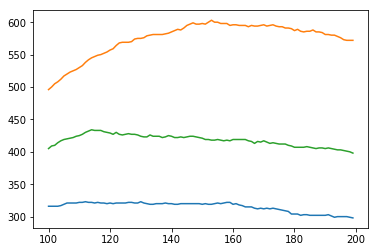

In [417]:
plt.plot(xs, ys_tech)
plt.plot(xs, ys_hum)
plt.plot(xs, ys_nat)
plt.show()

In [418]:
tech_words, hum_words, natural_words = get_words(125)

In [419]:
print(len(tech_words), len(hum_words), len(natural_words)) # 100

321 569 427


In [420]:
all_words = []
all_words.extend(tech_words)
all_words.extend(hum_words)
all_words.extend(natural_words)

features = dict(zip(all_words, range(len(all_words))))

## Создание датасета 

In [421]:
def get_document(doc_id):
    request_url = "http://localhost:3000/get-document?doc_id=%s" % doc_id
    response = urllib.request.urlopen(request_url).read().decode("utf-8")
    return json.loads(response) if response else None

In [422]:
tech_docs_texts = []
for doc in tech_docs_ids:
    tech_docs_texts.append(get_document(doc)["modalities"]["text"])
    
hum_docs_texts = []
for doc in hum_docs_ids:
    hum_docs_texts.append(get_document(doc)["modalities"]["text"])
    
natural_docs_texts = []
for doc in natural_docs_ids:
    natural_docs_texts.append(get_document(doc)["modalities"]["text"])
    
all_docs_texts = []
for doc in all_docs_ids:
    all_docs_texts.append(get_document(doc)["modalities"]["text"])

In [423]:
doc_ids = list(tech_docs_ids)
doc_ids.extend(hum_docs_ids)
doc_ids.extend(natural_docs_ids)

train_data = []
all_data = []
target = []

class_codes = {
    "tech": 0,
    "hum": 1,
    "natural": 2
}

for doc in tech_docs_texts:
    X = np.zeros(len(all_words))
    for word in doc:
        t = features.get(word, -1)
        if t > 0: X[t] = 1
    train_data.append(X)
    target.append(class_codes["tech"])
    
for doc in hum_docs_texts:
    X = np.zeros(len(all_words))
    for word in doc:
        t = features.get(word, -1)
        if t > 0: X[t] = 1
    train_data.append(X)
    target.append(class_codes["hum"])

for doc in natural_docs_texts:
    X = np.zeros(len(all_words))
    for word in doc:
        t = features.get(word, -1)
        if t > 0: X[t] = 1
    train_data.append(X)
    target.append(class_codes["natural"])
    
for doc in all_docs_texts:
    X = np.zeros(len(all_words))
    for word in doc:
        t = features.get(word, -1)
        if t > 0: X[t] = 1
    all_data.append(X)
    
train_data = array(train_data)
all_data = array(all_data)
target = array(target)

In [425]:
len(train_data)

2646

In [426]:
np.mean([sum(p) for p in train_data])

8.2800453514739232

## Обучение и классификация

In [427]:
train_data.shape

(2646, 1317)

In [434]:
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

alg1 = LogisticRegression(penalty='l2')
alg2 = LogisticRegression(penalty='l1')

print("LR-l2: %.3f" % (np.mean(cross_val_score(alg1, train_data, target, cv=10))))
print("LR-l1: %.3f" % (np.mean(cross_val_score(alg2, train_data, target, cv=10))))

LR-l2: 0.793
LR-l1: 0.793


## Экспорт результатов

In [435]:
alg1.fit(train_data, target)
answers = dict(zip(all_docs_ids, alg1.predict_proba(all_data).round(2)))
with open("../server/docs_class_probabilities.dump", "wb") as file:
    pickle.dump(answers, file)

---